## Customer Service Request Analysis

In [18]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib import style
style.use('ggplot')
mpl.rcParams['lines.linewidth'] = 2
import warnings
warnings.filterwarnings("ignore")
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

## Import Customer Request data

In [25]:
# read data from dataset.
# df = pd.read_csv('Project1/311_Service_Requests_from_2010_to_Present.csv')
df = pd.read_csv("311_Service_Requests_from_2010_to_Present.csv", header=0,
    sep=',', parse_dates=['Created Date', 'Closed Date', 'Resolution Action Updated Date'],index_col='Unique Key')

### convert the columns ‘Created Date’ and Closed Date’ to datetime datatype and create a new column ‘Request_Closing_Time’ as the time elapsed between request creation and request closing.

Remove null and junk data like closed date < create date

In [26]:
#function prepare data
def prepareData(df):
    df['Resolution_Time'] = (df['Closed Date'] - df['Created Date']).dt.total_seconds() #days/3600
    df_clean=df[df['Resolution_Time'].notnull()]
    df_perfect = df_clean[df_clean['Closed Date'] >= df_clean['Created Date']]
    df_perfect['Day of Week'] = df_perfect['Created Date'].dt.dayofweek
    df_perfect['Day of Month'] = df_perfect['Created Date'].dt.day
    df_perfect['Month'] = df_perfect['Created Date'].dt.month
    df_perfect['Year'] = df_perfect['Created Date'].dt.year
    df_perfect=df_perfect[df_perfect.Borough!='Unspecified']
    return df_perfect

In [27]:
df_perfect = prepareData(df)
df_perfect.shape

(298068, 57)

### Major Insights Patterns.

<AxesSubplot:title={'center':'Most common Complaints'}>

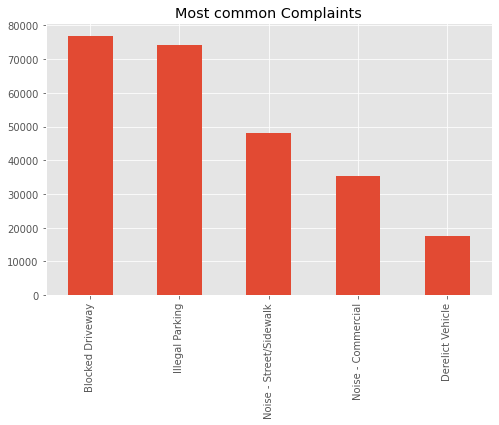

In [29]:
#Most frequent Complaints
(df_perfect['Complaint Type'].value_counts()).head().plot(kind='bar', figsize=(8,5), title = 'Most common Complaints')

<AxesSubplot:title={'center':'Least frequent Complaints'}>

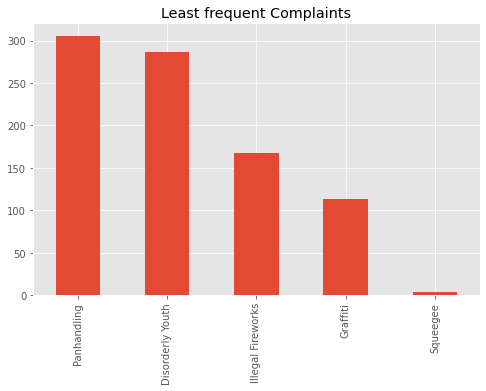

In [30]:
#Least frequent Complaints
(df_perfect['Complaint Type'].value_counts()).tail().plot(kind='bar', figsize=(8,5), title = 'Least frequent Complaints')

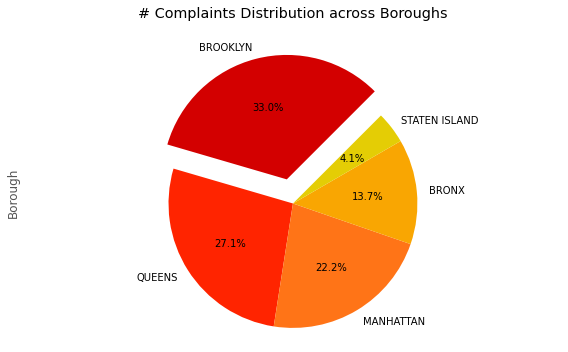

In [31]:
# complaints distribution across Boroughs
colors = ['#D30000','#FF2400','#FF7417','#F9A602','#E4CD05','#a7993f','#cc566a']
df_perfect['Borough'].value_counts().plot(kind='pie',autopct='%1.1f%%', explode = (0.2, 0, 0, 0, 0), 
                        startangle=45, shadow=False, colors = colors, figsize = (8,5))
plt.axis('equal')
plt.title('# Complaints Distribution across Boroughs\n')
plt.tight_layout()
plt.show()

In [32]:
#Analysis for Brooklyn borough which has highest number of complains
df_Brooklyn = df_perfect[df_perfect['Borough']=='BROOKLYN']

In [33]:
df_Brooklyn.shape

(98295, 57)

<AxesSubplot:title={'center':'Most Frequent Complaints in Brooklyn'}>

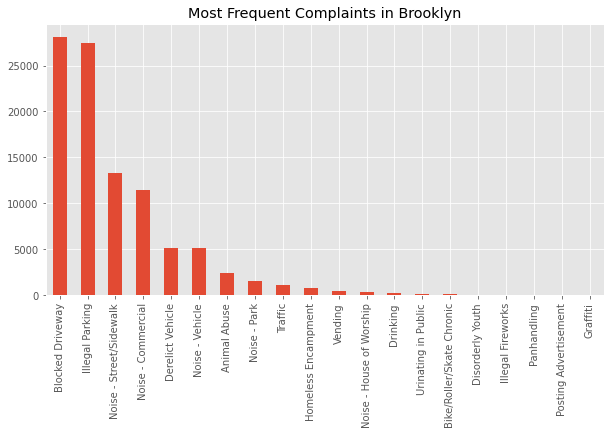

In [34]:
(df_Brooklyn['Complaint Type'].value_counts()).head(20).plot(kind='bar', figsize=(10,5),title = 'Most Frequent Complaints in Brooklyn')

<AxesSubplot:title={'center':'Location Type vs # Complaints'}>

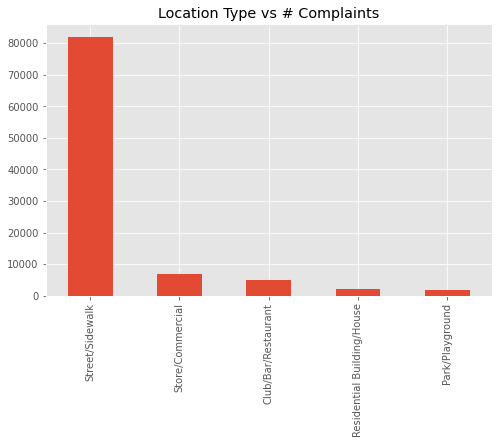

In [35]:
#location type vs complaints
(df_Brooklyn['Location Type'].value_counts()).head().plot(kind='bar', figsize=(8,5),title = 'Location Type vs # Complaints')

In [36]:
#Anlysis of Most Frequent complaint in Brooklyn
df_perfect[df_perfect['Complaint Type'] == 'Blocked Driveway']['Descriptor'].value_counts()

No Access         56786
Partial Access    19967
Name: Descriptor, dtype: int64

In [37]:
df_Brook_blocked = df_Brooklyn[df_Brooklyn['Complaint Type'] == 'Blocked Driveway']

(-74.04994270070343, -73.84653002929657, 40.5645918345, 40.7464960955)

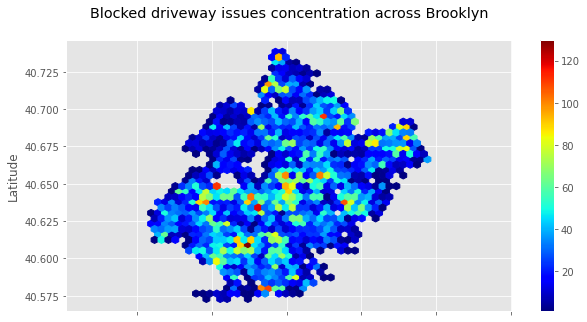

In [38]:
df_Brook_blocked.plot(
    kind='hexbin', x='Longitude', y='Latitude', gridsize=40, title = 'Blocked driveway issues concentration across Brooklyn\n',
    colormap='jet', mincnt=1, figsize=(10,5)).axis('equal')

<AxesSubplot:title={'center':'Volume of Blocked driveway issues by Month\n'}>

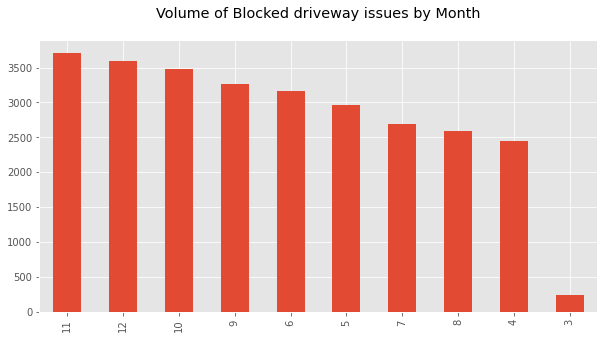

In [39]:
df_Brook_blocked['Month'].value_counts().plot(kind = 'bar',figsize=(10,5), title = 'Volume of Blocked driveway issues by Month\n')

##### ‘Request_Closing_Time’ in Seconds, grouping them for different locations, order by complaint type

In [40]:
df_avg_res_time_city = df_perfect.groupby(['City','Complaint Type']).Resolution_Time.mean()
#df_perfect.sort_values('Complaint Type').groupby('City')
df_avg_res_time_city.head(25)

City     Complaint Type           
ARVERNE  Animal Abuse                  7753.052632
         Blocked Driveway              9093.485714
         Derelict Vehicle             10685.592593
         Disorderly Youth             12928.500000
         Drinking                       859.000000
         Graffiti                      5520.000000
         Homeless Encampment           6533.250000
         Illegal Parking               8338.913793
         Noise - Commercial            8234.000000
         Noise - House of Worship      5623.909091
         Noise - Park                  4620.000000
         Noise - Street/Sidewalk       7172.620690
         Noise - Vehicle               6695.571429
         Panhandling                   3720.000000
         Urinating in Public           2491.000000
         Vending                       1740.000000
ASTORIA  Animal Abuse                 18000.608000
         Bike/Roller/Skate Chronic     6261.533333
         Blocked Driveway             17338.024

### Average response time across complaint types in seconds

In [41]:
#Average response time in seconds across complaint types
df_avg_res_time = df_perfect.groupby('Complaint Type').Resolution_Time.mean().sort_values(ascending=True)
df_avg_res_time.head(21)

Complaint Type
Posting Advertisement         7112.891975
Illegal Fireworks             9940.101190
Noise - Commercial           11291.632884
Noise - House of Worship     11495.874058
Noise - Park                 12246.158157
Noise - Street/Sidewalk      12377.738882
Traffic                      12415.252002
Disorderly Youth             12810.902098
Noise - Vehicle              12918.914430
Urinating in Public          13055.991554
Bike/Roller/Skate Chronic    13523.545024
Drinking                     13879.309748
Vending                      14449.060358
Squeegee                     14564.250000
Homeless Encampment          15716.052536
Panhandling                  15741.963934
Illegal Parking              16149.479466
Blocked Driveway             17057.298659
Animal Abuse                 18768.513712
Graffiti                     25744.504425
Derelict Vehicle             26445.913579
Name: Resolution_Time, dtype: float64

#### From the above data null hypothesis can be rejected . Since the average response time across complaint type are not equal.Null Hypothesis : Average response time across complaint type are equal. Alternate Hypothesis : Average response time across complaint type are equal

#### Following complains have resolution times which are very close. Disorderly Youth 12810.902098 Noise - Vehicle 12918.914430 One group can be formed for these complaints and one way Anova for this can be performed

In [43]:
df_dis_youth = df_perfect[df_perfect['Complaint Type']=='Disorderly Youth']
df_dis_youth = df_dis_youth.loc[:,['Resolution_Time']]
df_dis_youth.head()

,Resolution_Time
Unique Key,
32274507,713.0
32244468,4605.0
32225263,2345.0
32227341,19415.0
32191432,6849.0


In [44]:
df_noise_veh = df_perfect[df_perfect['Complaint Type']=='Noise - Vehicle']
df_noise_veh = df_noise_veh.loc[:,['Resolution_Time']]
df_noise_veh.head()

,Resolution_Time
Unique Key,
32307159,22949.0
32308722,7254.0
32308107,11319.0
32308108,10937.0
32306622,2615.0


In [45]:
df_type_res = df_perfect.loc[:, ['Complaint Type','Resolution_Time']]
df_type_res.head()
df_type_res.columns

Index(['Complaint Type', 'Resolution_Time'], dtype='object')

In [46]:
# stats f_oneway functions takes the groups as input and returns F and P-value
fvalue, pvalue = stats.f_oneway(df_dis_youth, df_noise_veh)
pvalue

array([0.91269878])

Null hypothesis to be accepted for Disorderly Youth and Noise - Vehicle p-value close to 1

#### One Way Anova for Posting Advertisement and Derelict Vehicle

In [47]:
df_post_ad = df_perfect[df_perfect['Complaint Type']=='Posting Advertisement']
df_post_ad = df_post_ad.loc[:,['Resolution_Time']]
df_post_ad.head()

,Resolution_Time
Unique Key,
32306752,7596.0
32307464,7745.0
32308949,7834.0
32307323,8042.0
32306034,8137.0


In [48]:
df_der_veh = df_perfect[df_perfect['Complaint Type']=='Derelict Vehicle']
df_der_veh = df_der_veh.loc[:,['Resolution_Time']]
df_der_veh.head()

,Resolution_Time
Unique Key,
32309424,37763.0
32306497,14221.0
32305124,4913.0
32308002,14879.0
32305798,2712.0


In [49]:
# stats f_oneway functions takes the groups as input and returns F and P-value
fvalue, pvalue = stats.f_oneway(df_post_ad, df_der_veh) 
pvalue

array([7.28776953e-35])

Null hypothesis for Posting Advertisement and Derelict Vehicle to be rejected p-value < 0.05

#### Anova table for complain type and resolution time

In [51]:
# get ANOVA table for complain type and resolution time

# reshape the d dataframe suitable for statsmodels package 
df_perfect['Complaint_Type']=df_perfect['Complaint Type']
df_type_res = df_perfect.loc[:, ['Complaint_Type','Resolution_Time']]  #Complaint Type

# Ordinary Least Squares (OLS) model
model = ols('Resolution_Time ~ Complaint_Type', data=df_type_res).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
Complaint_Type,3.784839e+12,20.0,410.258598,0.0
Residual,1.374816e+14,298047.0,NaN,NaN


Null Hypothesis to be rejected since p-value < 0.05

#### Crosstab and Chi Square test for Location and Complaint type

In [52]:
df_city_type = pd.crosstab(df_perfect.City , df_perfect.Complaint_Type)

In [53]:
# chi-squared test with similar proportions
from scipy.stats import chi2_contingency
from scipy.stats import chi2

# contingency table
table = df_city_type

#print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)

# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
    
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

dof=1040
[[5.73350737e+00 3.11515400e-01 5.66574169e+01 ... 3.31741755e+00
  4.37007385e-01 2.80068584e+00]
 [1.64968644e+02 8.96314763e+00 1.63018841e+03 ... 9.54511504e+01
  1.25738943e+01 8.05833700e+01]
 [1.86599603e+01 1.01384103e+00 1.84394139e+02 ... 1.07966862e+01
  1.42226040e+00 9.11495938e+00]
 ...
 [6.41892211e+01 3.48755650e+00 6.34305536e+02 ... 3.71399974e+01
  4.89249632e+00 3.13549511e+01]
 [9.23615914e+01 5.01822989e+00 9.12699480e+02 ... 5.34405809e+01
  7.03979170e+00 4.51165029e+01]
 [3.12736765e+00 1.69917491e-01 3.09040456e+01 ... 1.80950048e+00
  2.38367665e-01 1.52764682e+00]]
probability=0.950, critical=1116.137, stat=110425.867
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)
